This tutorial covers the comparison between time series signals and the calculation of metrics. Starting from simple subtraction, metrics like root mean squared error for upper and lower boundaries (envelope) are calculated. The tutorial also illustrates some helper functions for plotting (e.g. fill between two time series).

# Addition and Subtraction
First we create a time series with two curves between 0 and 5 seconds. The time samples are randomly varied (sample time is not constant). This could be for example results of simulations with an adaptive (variable) step solver. Note that there is a separate tutorial on signal generation.  

<Axes: xlabel='time'>

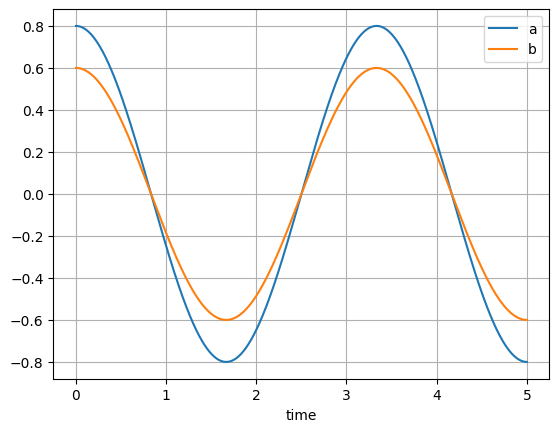

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append(r"..\src")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from trimes.signal_generation import PeriodicSignal

t_start = 0
t_end = 5
average_sample_time = 1e-3
time = np.arange(t_start, t_end, average_sample_time)
time = time + (np.random.rand(len(time)) - 0.5) * 1e-5

sig_a = PeriodicSignal(time, mag=0.8, f=0.3)
sig_b = PeriodicSignal(time, mag=0.6, f=0.3)

df_ts = pd.DataFrame({"a": sig_a.get_signal(), "b": sig_b.get_signal()}, index=time)
df_ts.index.name = "time"
df_ts.plot(grid=True)

Next we create a reference signal with a different sampling time compared to above. 

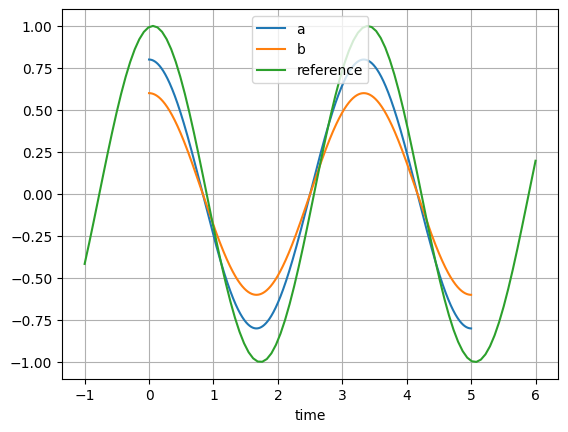

In [2]:
time = np.linspace(t_start - 1, t_end + 1, 100)
sig_ref = PeriodicSignal(time, mag=1, f=0.3, phi=-2)
series_reference = sig_ref.get_signal_series()

df_ts.plot()
series_reference.name = "reference"
series_reference.plot(grid=True)

plt.legend(loc="upper center")

We calculate the difference between signals 'a'/'b' and the reference. Signals 'a'/'b' are automatically resampled according to the reference (resample_ts=True).

A diagram with two y-axes is used for visualization (original signals on the left axis, difference on the right). In addition, the area between 'b' and 'reference' is filled.

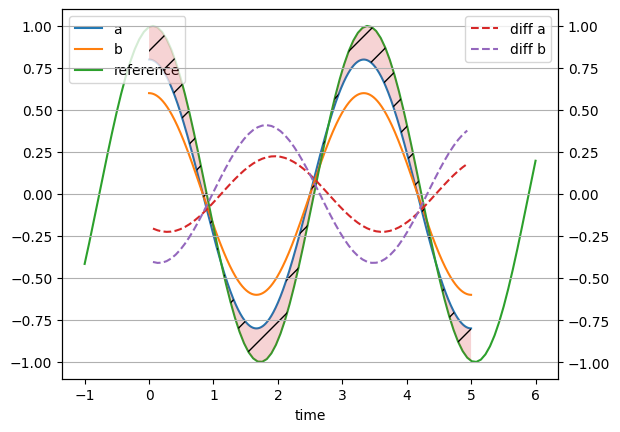

In [3]:
from trimes.comparison import subtract
from trimes.plots import plot_2y, fill_between

difference = subtract(df_ts, series_reference, resample_ts=True)
difference.columns = ("diff a", "diff b")

signals_a_b_and_reference = pd.concat([df_ts, series_reference])
ax1, ax2 = plot_2y(
    signals_a_b_and_reference, difference, kwargs_ax2={"linestyle": "--"}
)
fill_between(df_ts["a"], series_reference, alpha=0.2, hatch="/")
plt.grid()

Addition works similar:

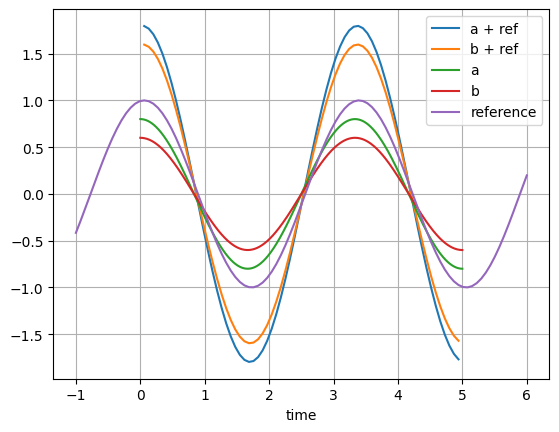

In [4]:
from trimes.comparison import add

sum = add(df_ts, series_reference, resample_ts=True)
sum.columns = ("a + ref", "b + ref")
ax = sum.plot()
signals_a_b_and_reference.plot(ax=ax)
plt.grid()

# Boundaries and Envelopes

## Create Boundaries as Linear Time Series Signals
We will create boundaries and check whether a time series signal remains within the envelope and calculate error metrics.

<Axes: xlabel='time'>

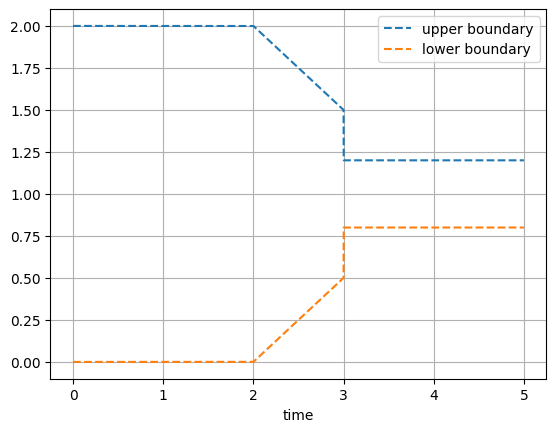

In [22]:
from trimes.signal_generation import linear_time_series, mirror_y

t = (0, 2, 3, 3, 5)
y = (2, 2, 1.5, 1.2, 1.2)
sample_time = 1e-3
ts = linear_time_series(t, y, sample_time)
ts_envelope = mirror_y(ts, 1, inplace=True)
ts_envelope.columns = ("upper boundary", "lower boundary")
ts_envelope.plot(grid=True, linestyle="--")

Create the periodic signal:

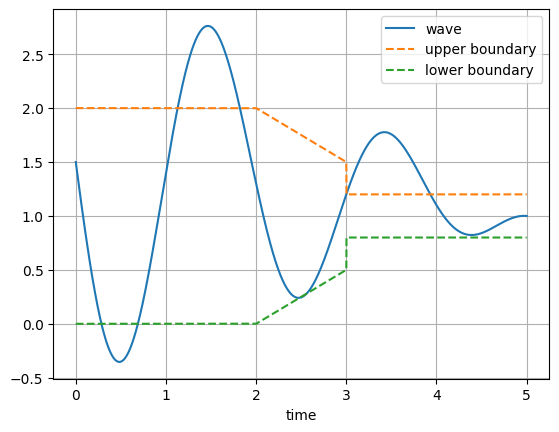

In [6]:
from trimes.signal_generation import PeriodicSignal
from trimes.plots import fill_between

signal = PeriodicSignal(
    np.arange(0, 5 + sample_time, sample_time),
    f=0.5,
    offset=(1.5, 1),
    mag=(2, 0.01),
    phi=np.pi / 2,
)
wave = signal.get_signal_series()
wave.name = "wave"
ax = plt.subplot()
wave.plot(ax=ax)
ts_envelope.plot(ax=ax, linestyle="--")
plt.legend()
plt.grid()

## Check Boundaries
`greater_than_series` and `smaller_than_series` compare the wave to the boundary and return a boolean array

In [7]:
from trimes.comparison import greater_than_series

upper_boundary = ts_envelope.iloc[:, 0]
greater_than_series(wave, upper_boundary)

array([False, False, False, ..., False, False, False])

`apply_operator_series` can be used in a similar way using any suitable operator from the built-in `operator` module.

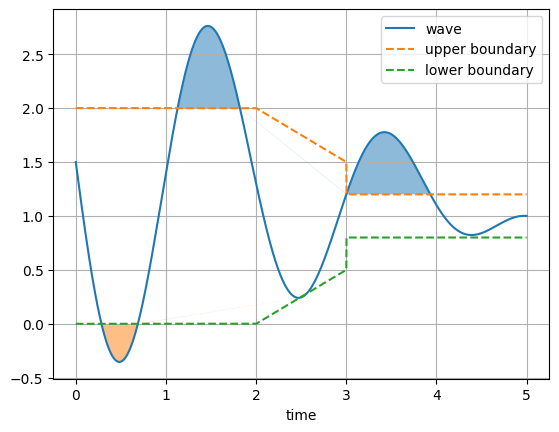

In [10]:
import operator
from trimes.comparison import apply_operator_series

greater = apply_operator_series(wave, ts_envelope.iloc[:, 0], operator.gt)
smaller = apply_operator_series(wave, ts_envelope.iloc[:, 1], operator.lt)

ax = plt.subplot()
wave.plot(ax=ax)

ts_envelope.plot(ax=ax, linestyle="--")
fill_between(wave.iloc[greater], ts_envelope.iloc[greater, 0], alpha=0.5)
fill_between(wave.iloc[smaller], ts_envelope.iloc[smaller, 1], alpha=0.5)
plt.legend()
plt.grid()

For convenience there is also a method that checks upper and lower boundary at once:

In [11]:
from trimes.comparison import outside_envelope

outside_envelope(wave, ts_envelope)

array([False, False, False, ..., False, False, False])

## Calculate Metric
Next we calculate metrics such as the area where the wave exceeds the envelope. `comparison_series`/`comparison_df` calculate any error metric (default is `itegral_abs_error`, i.e. area) for series and dataframes. Some metrics are defined in `trimes.metrics`. Further metrics from the *scikit-learn* package can be used.     

In [19]:
from trimes.comparison import comparison_series, comparison_df
from trimes.metrics import integral_squared_error, integral_abs_error
from sklearn.metrics import root_mean_squared_error

print(
    comparison_series(
        wave,
        ts_envelope.iloc[:, 0],
        operator.gt,
    )
)
print(
    comparison_series(
        wave, ts_envelope.iloc[:, 1], operator.lt, metric=root_mean_squared_error
    )
)
df_waves = pd.concat([wave, wave * 1.1], axis=1)
print(
    comparison_df(
        df_waves,
        ts_envelope.iloc[:, 0],
        operator.gt,
        metric=integral_abs_error,
    )
)

0.6832649919854159
0.07301156189253198
[0.68326499 1.01496933]


For convenience there are also methods for envelopes instead of a single boundarie.

In [21]:
from trimes.comparison import envelope_comparison_series, envelope_comparison_df

envelope_comparison_series(wave, ts_envelope)
envelope_comparison_df(df_waves, ts_envelope)

array([0.77815754, 1.11895373])

In [14]:
from trimes.comparison import envelope_comparison_df

envelope_comparison_df(pd.concat([wave, wave], axis=1), ts_envelope)

array([0.77815754, 0.77815754])

# Step Response Info
*trimes* provides an interface to the *control* package to get the step response info (overshoot etc.) of time series. Let's first create a step response signal.

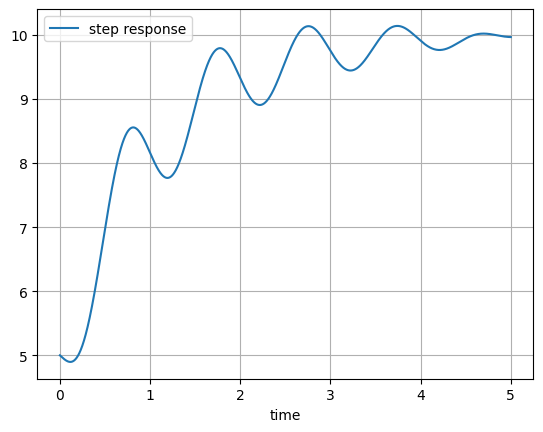

In [15]:
t = np.arange(0, 5 + sample_time, sample_time)
offset = 10 - 5 * np.exp(-t)
step_response = PeriodicSignal(
    np.arange(0, 5 + sample_time, sample_time),
    f=1,
    offset=offset,
    mag=(1, 0.01),
    phi=np.pi / 2,
)
step_series = step_response.get_signal_series()
step_series.name = "step response"
step_series.plot(grid=True)
plt.legend()

Get the step response info. Note that the y-values in the results are relative to the initial value. 

In [16]:
from trimes.control import step_info_series

info = step_info_series(step_series)
info

{'RiseTime': np.float64(1.303),
 'SettlingTime': np.float64(4.405),
 'SettlingMin': np.float64(3.906303780009649),
 'SettlingMax': np.float64(5.140223553657352),
 'Overshoot': np.float64(3.501861127732394),
 'Undershoot': np.float64(2.0758071455346307),
 'Peak': np.float64(5.140223553657352),
 'PeakTime': np.float64(3.742),
 'SteadyStateValue': np.float64(4.966310265004573)}

There is also a function to illustrate the results.

4.896908976649615


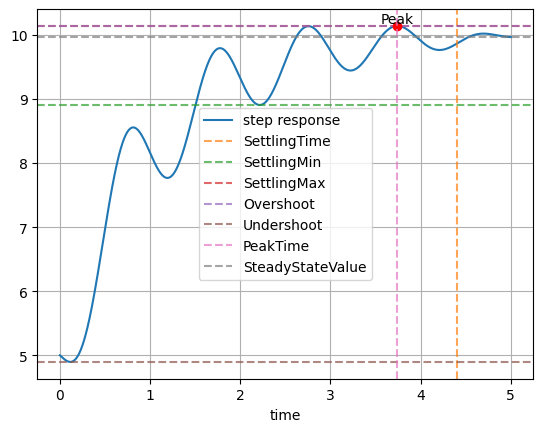

In [23]:
from trimes.control import plot_step_info

step_series.plot(grid=True)
plot_step_info(step_series, info)
plt.legend()